In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pickle as pkl
import os

In [2]:
save_path = "C:\\Users\\Johannes\\Documents\\Uni\\Master's_Thesis\\SCDCdm\\data\\model_comparison\\model_comparison_new_001\\"

results = []

for f in os.listdir(save_path):
    with open(save_path + f, "rb") as file:
        r = pkl.load(file)
        if f == "ALDEx2_alr_results.pkl":
            r.loc[:, "model"] = "ALDEx2_alr"
            results.append(r)
        elif f == "old_results":
            old_results = r
        else:
            results.append(r)

In [3]:
all_res = pd.concat(results)

print(all_res)

   n_cell_types n_cells n_controls n_cases  Base Increase  log-fold increase  \
0             5    5000          8       8   400      200               0.58   
1             5    5000          8       8   400      200               0.58   
2             5    5000          8       8   400      200               0.58   
3             5    5000          8       8   400      200               0.58   
4             5    5000          8       8   400      200               0.58   
..          ...     ...        ...     ...   ...      ...                ...   
15            5    5000          2       2  1000      500               0.58   
16            5    5000          2       2  1000      500               0.58   
17            5    5000          2       2  1000      500               0.58   
18            5    5000          2       2  1000      500               0.58   
19            5    5000          2       2  1000      500               0.58   

                                      b

In [4]:
# Get only relevant models for plots
models_rel = ["scdcdm", "simple_dm", "scDC (SydneyBioX)", "ancom", "ALDEx2_alr", "alr_ttest", "alr_wilcoxon", "dirichreg", "Haber", "ttest"]
plot_df = all_res.loc[all_res["model"].isin(models_rel)]


In [5]:
plot_df.loc[:, 'model'] = pd.Categorical(plot_df['model'], models_rel)
plot_df = plot_df.sort_values("model")

linestyles = dict(zip(models_rel, [0, 1, 0, 1, 3, 0, 1, 3, 0, 1]))
colors = dict(zip(models_rel, [0, 0, 1, 1, 1, 2, 2, 2, 3, 3]))

plot_df.loc[:, "linestyle"] = [linestyles[x] for x in plot_df["model"]]
plot_df.loc[:, "color"] = [colors[x] for x in plot_df["model"]]

In [6]:
leg_labels = ["SCDCdm", "Simple DM", "scDC (SydneyBioX)", "ancom", "ALDEx2",
              "ALR + t", "ALR + Wilcoxon", "Dirichlet regression", "Poisson regression", "t-test"]
leg_labels = pd.unique(plot_df["model"])
print(leg_labels)

['scdcdm']
Categories (1, object): ['scdcdm']


In [7]:
print(plot_df.loc[plot_df["model"]=="scdcdm", ["tp", "tn", "fp", "fn"]].sum())

tp     4943
tn    15713
fp     4287
fn       57
dtype: int64


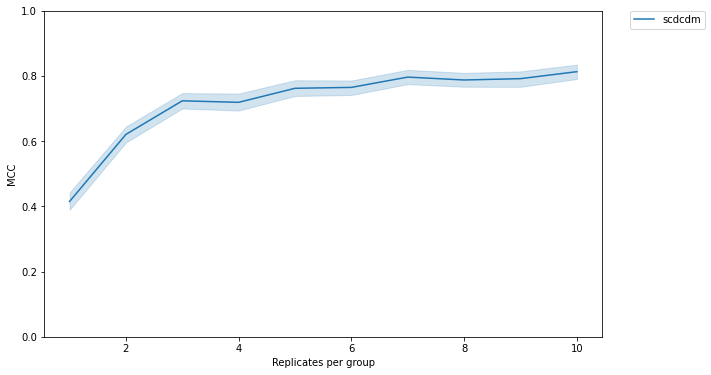

In [8]:
plot_path = "C:\\Users\\Johannes\\Documents\\Uni\\Master's_Thesis\\SCDCdm\\data\\benchmark_results"
#palette = sns.color_palette(['#e41a1c','#377eb8','#4daf4a','#984ea3'])
#palette = sns.color_palette(['#e41a1c'])

# Plot for concept fig
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=plot_df, x="n_controls", y="mcc",
             hue="color",
             # palette=palette,
             style="linestyle",
             # dashes=[(1,0), (4, 4), (7, 2, 2, 2)],
             ax=ax,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           labels=leg_labels
           )
ax.set(xlabel="Replicates per group", ylabel="MCC", ylim=[0,1])

# plt.savefig(plot_path + "\\model_comparison_replicates_confint_extended.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "\\model_comparison_replicates_confint_extended.png", format="png", bbox_inches="tight")

plt.show()

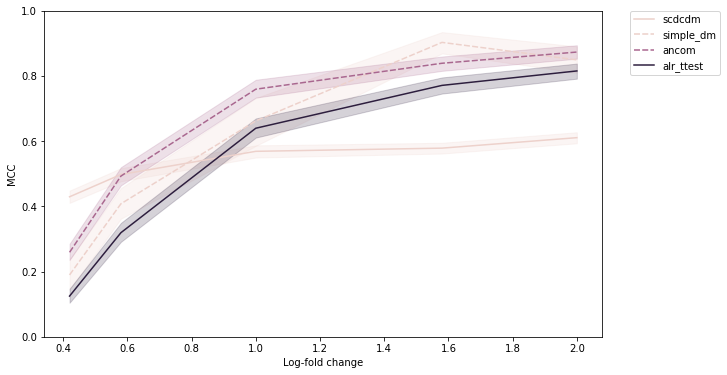

In [9]:
# Plot for concept fig
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=plot_df, x="log-fold increase", y="mcc",
             hue="color",
             style="linestyle",
             # dashes=[(1,0), (4, 4), (7, 2, 2, 2)],
             ax=ax,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=leg_labels)
ax.set(xlabel="Log-fold change", ylabel="MCC", ylim=[0,1])

# plt.savefig(plot_path + "\\model_comparison_replicates_confint_extended.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "\\model_comparison_replicates_confint_extended.png", format="png", bbox_inches="tight")

plt.show()


